# Chapter 12 - Autocorrelation in Time Series Data

# 12.1 Problems of Autocorrelation (p 481)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.regressionplots as smplot
from statsmodels.stats.api import het_breuschpagan, anova_lm, durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols, wls, rlm, glsar
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
import itertools as iter


DATA_DIR = "../data"
yhat = '\u0177'
square = '\u00b2'

### Table 12.1 (p 482)

Example of Positively Autocorrelated Error Terms

In [3]:
u = [None, 0.5, -0.7, 0.3, 0, -2.3, -1.9, 0.2, -0.3, 0.2, -0.1]
t = range(len(u))
e = [0]*len(u)
estart = 3
for i in t:
    if i==0:
        e[i] = estart
        continue
    e[i] = e[i-1] + u[i]

df = pd.DataFrame({
    "t": t,
    "u": u,
    "e": e,
    "y": 2 + 0.5*np.array(t) + np.array(e)
})

df

,t,u,e,y
0,0,NaN,3.0,5.0
1,1,0.5,3.5,6.0
2,2,-0.7,2.8,5.8
3,3,0.3,3.1,6.6
4,4,0.0,3.1,7.1
5,5,-2.3,0.8,5.3
6,6,-1.9,-1.1,3.9
7,7,0.2,-0.9,4.6
8,8,-0.3,-1.2,4.8
9,9,0.2,-1.0,5.5


### Figure 12.1 (p 483)

Example of Positively Autocorrelated Error Terms

(-3.0, 5.0)

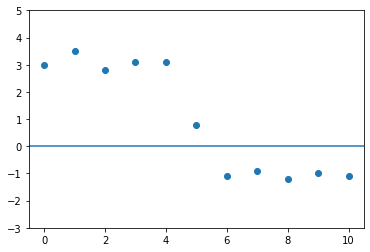

In [4]:
plt.scatter(t, e)
plt.axhline(y=0)
plt.ylim(-3, 5)

### Figure 12.2 (p 483)

Regression with Positively Autocorrelated Error Terms

##### Note

I'm leaving out Figure 12.2(c) because yes, under less autocorrelated series, you would have a more accomodating fit.

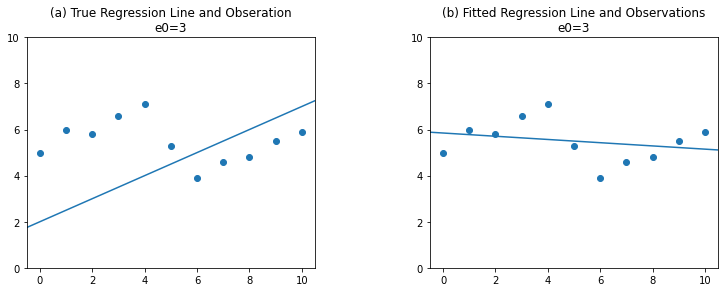

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0].scatter(df.index, df.y)
axes[0].axline((0,2), slope=0.5)  # Plots an intercept tuple and slope
axes[0].set_ylim(0, 10)

axes[1].scatter(df.index, df.y)
axes[1].axline((0,5.85), slope=-0.07)  # Plots an intercept tuple and slope
axes[1].set_ylim(0, 10)

axes[0].set_title("(a) True Regression Line and Obseration\ne0=3")
axes[1].set_title("(b) Fitted Regression Line and Observations\ne0=3")
plt.show()



# 12.2 First-Order Autoregressive Error Model (p 484)

This brief section explains that the form we saw above is called the first-order autoregressive, or AR(1), process, consisting of

$Y_t=\beta_0 + \beta_1 X_t + \epsilon_t$

$\epsilon_t = \rho\epsilon_{t-1} + u_t$

This is exactly the simple linear regression model (2.1) with a different error structure, where a period's errer term consists partially ($\rho$) of the previous period's error. This equivalent is true of multiple regression. 

Then there are a bunch of properties about these error terms--namely, expectation of 0 (12.3), constant variance equal to $\frac{\sigma^2}{1-\rho^2}$ (12.4). Then a bunch of correlation stuff (12.5-12.8). 

# 12.3 Durbin-Watson Test for Autocorrelation (p 487)

### Input the Blaisdell Company Data

In [6]:
df = pd.read_pickle(f"{DATA_DIR}/CH12TA02.xz")
df.columns = ['Y', 'X']
model = ols("Y ~ X", df).fit()

### Table 12.2 (p 489)

Data, Regression Results, and Durbin-Watson Test Calculations -- Blaisdell Company Example

The Durbin-Watson tests whether or not there is enough evidence to suggest AR(1) autocorrelation as identified by $\rho$. Namely,

$H_0: \rho = 0$

$H_a: \rho > 0$

The test statistic is derived from the formula (12.14). Recognize $n$ here is 1 based instead of 0 based.

$D = \frac{\Sigma^2_{t=2} (e_t - e_{t-1})^2}{\Sigma^n_{t=1} e^2_t}$

The exact critical values are difficult to obtain (and text does not discuss). Instead, Durbin and Watson have obtained lower and upper bounds $d_L$ and $d_U$ such that if $D$ falls outside of these bounds lead to a definite decision. In particular,

If $D > d_U, conclude H_0$

If $D < d_L, conclude H_a$

If $d_L <= D <= D_U, inconclusive$

##### Note

The model summary provides a Durbin-Watson test statistic already, but I show the stats library contains a `durbin_watson` function that can provide you that number directly. However, I have not found any automatic lookups for critical values other than looking in a table or using a general rule when $n$ is large.

In [7]:
idx = [199801, 199802, 199803, 199804, 
    199901, 199902, 199903, 199904, 
    200001, 200002, 200003, 200004,
    200101, 200102, 200103, 200104, 
    200201, 200202, 200204]

pd.DataFrame({
    "(1) Company Sales": df.Y,
    "(2) Industry Sales": df.X,
    "(3) Residual": model.resid,
    "(4)": model.resid.diff(),
    "(5)": model.resid.diff()**2,
    "(6)": model.resid**2
})

,(1) Company Sales,(2) Industry Sales,(3) Residual,(4),(5),(6)
0,20.96,127.3,-0.026052,NaN,NaN,0.000679
1,21.40,130.0,-0.062015,-0.035964,1.293380e-03,0.003846
2,21.96,132.7,0.022021,0.084036,7.062118e-03,0.000485
3,21.52,129.4,0.163754,0.141733,2.008832e-02,0.026815
4,22.39,135.0,0.046570,-0.117184,1.373203e-02,0.002169
5,22.76,137.1,0.046377,-0.000194,3.759878e-08,0.002151
6,23.48,141.2,0.043617,-0.002760,7.614989e-06,0.001902
7,23.66,142.8,-0.058435,-0.102052,1.041471e-02,0.003415
8,24.10,145.5,-0.094399,-0.035964,1.293380e-03,0.008911
9,24.01,145.3,-0.149142,-0.054743,2.996844e-03,0.022243


In [8]:
display(anova_lm(model))
model.summary()

,df,sum_sq,mean_sq,F,PR(>F)
X,1.0,110.256878,110.256878,14888.143557,1.013155e-27
Residual,18.0,0.133302,0.007406,NaN,NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.489e+04
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           1.01e-27
Time:                        17:03:59   Log-Likelihood:                 21.730
No. Observations:                  20   AIC:                            -39.46
Df Residuals:                      18   BIC:                            -37.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4548      0.214     -6.793      0.000      -1.905      -1.005
X              0.1763      0.001    122.017      0.000       0.173       0.179
==============================================================================
Omnibus:                        0.074   Durbin-Watson:                   0.735
Prob(Omnibus):                  0.964   Jarque-Bera (JB):                0.300
Skew:                          -0.032   Prob(JB):                        0.861
Kurtosis:                       2.404   Cond. No.                     1.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
durbin_watson(model.resid) < 0.95, durbin_watson(model.resid) > 1.15

(True, False)

### Figure 12.3 (p 489)

Residuals Plotted against Time -- Blaisdell Company Example

(-0.2, 0.2)

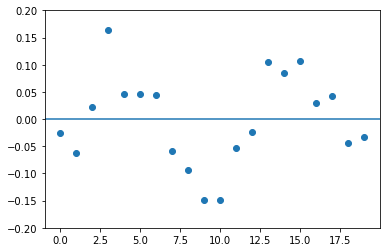

In [10]:
plt.scatter(df.index, model.resid)
plt.axhline(y=0)
plt.ylim(-0.2, 0.2)

# 12.4 Remedial Measures for Autocorrelation (p 490)

### Table 12.3 (p 493)

Calculations for Estimating $\rho$ with the Cochrane-Orcutt Procedure -- Blaisdell Company Example

The authors note that there are 2 approaches to remediating autocorrelation. One cause of autocorrelated error terms is the omission of one or more key predictor variables that have time-ordered effects on the response. This may be a specific data element or even including a trend variable (i.e., the index of time $t=1, 2, 3, ...$). 

When that is exhausted, only then should you look to transform your data to see if this AR model works. The methods discussed here all have the same pattern of redefining your endogenous and exogenous variables accordingly.

$Y^{'}_t = Y_t - \rho Y_{t-1}$

$X^{'}_t = X_t - \rho X_{t-1}$

By plugging in the AR model (12.1) into these lagged (shifted) components in this difference transformation, it can easily be shown that the combined error terms become $\epsilon_t - \rho\epsilon_{t-1}=u_t$. The final transformed model given by (12.16)

$Y^{'}_t = \beta_0(1-\rho) + \beta_1(X_t - \rho X_{t-1}) + u_t$

For convenience this is rewritten as (12.17)

$Y^{'}_t = \beta^{'}_0 + \beta^{'}_1 X^{'}_t + u_t$

where:

$Y^{'}_t=Y_t - \rho Y_{t-1}$

$X^{'}_t = X_t - \rho X_{t-1}$

$\beta^{'}_0=\beta_0(1-\rho)$

$\beta^{'}_1 = \beta_1$

Since $u_t$ are just the independent disturbance terms, this model contains error terms that are independent, unlike model (12.1). Note, the $MSE$ of this transformed model estimates the variance of our error term. Once an estimate of $\rho$ has been obtained, it is denoted by $r$.

If the fitted (12.16) model eliminated the autocorrelation in the error terms, we can transform it back by the following:

$b_0 = \frac{b^{'}_0}{1-r}$

$b_1 = b^{'}_1$

$s\{b_0\} = \frac{s\{b^{'}_0\}}{1-r}$

$s\{b_1\} = s\{b^{'}\}$

It is clear to see that this transformed model does not give us better slope estimates so much as it gives us more accurate (but not unbiased) standard errors and a corrected intercept. 

#### Cochrane-Orcutt Procedure

This estimates $\rho$ according to 

$r = \frac{\Sigma^n_{t=2} e_t e_{t-1}}{\Sigma^n_{t=2}e^2_{t-1}}$

If the Durbin-Watson test does not confirm a lack of autocorrelation, then this whole procedure can be iterated again until convergence or a max iteration has been reached. Additionally, note that the Durbin-Watson bounds ($d_L$ and $d_U$) are not the same because in the transformed model is now $n-1$ due to the shifted time series. This is true of any $AR(p)$ model. You will lose $p$ data points to the time shift. 

Comment here about $D \approx 2(1-r)$ and general bounds.

In [11]:
pd.DataFrame({
    "(1) et": model.resid,
    "(2) et-1": model.resid.shift(),
    "(3) et-1*et": model.resid * model.resid.shift(),
    "(4) et-1**2": model.resid.shift()**2
})

,(1) et,(2) et-1,(3) et-1*et,(4) et-1**2
0,-0.026052,NaN,NaN,NaN
1,-0.062015,-0.026052,0.001616,0.000679
2,0.022021,-0.062015,-0.001366,0.003846
3,0.163754,0.022021,0.003606,0.000485
4,0.046570,0.163754,0.007626,0.026815
5,0.046377,0.046570,0.002160,0.002169
6,0.043617,0.046377,0.002023,0.002151
7,-0.058435,0.043617,-0.002549,0.001902
8,-0.094399,-0.058435,0.005516,0.003415
9,-0.149142,-0.094399,0.014079,0.008911


In [12]:
pd.DataFrame({
    "et-1*et": np.sum(model.resid.shift()*model.resid),
    "et-1**2": np.sum(model.resid.shift()**2),
    "rho": np.sum(model.resid.shift()*model.resid) / np.sum(model.resid.shift()**2)
}, index=[1])

,et-1*et,et-1**2,rho
1,0.083448,0.132213,0.631164


### Figure 12.4 (p 493)

Transformed Variables and Regression Results for First Iteration with Cochrane-Orcutt Procedure -- Blaisdell Company Example

##### Note

As far as I know this process is available in statsmodels according to the General Least Squares Autocorrelated Regression ([GLSAR](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.GLSAR.html)) function shown below for comparison. Results for a `maxiter=1` does not produce identical results to the manual approach, so it clearly must be doing something slightly different.

In [14]:
rho = 0.631166
pd.DataFrame({
    "(1) Y": df.Y,
    "(2) X": df.X,
    "(3) Y'": df.Y - rho*df.Y.shift(),
    "(4) X'": df.X - rho*df.X.shift()
})

,(1) Y,(2) X,(3) Y',(4) X'
0,20.96,127.3,NaN,NaN
1,21.40,130.0,8.170761,49.652568
2,21.96,132.7,8.453048,50.648420
3,21.52,129.4,7.659595,45.644272
4,22.39,135.0,8.807308,53.327120
5,22.76,137.1,8.628193,51.892590
6,23.48,141.2,9.114662,54.667141
7,23.66,142.8,8.840222,53.679361
8,24.10,145.5,9.166612,55.369495
9,24.01,145.3,8.798899,53.465347


Here I'm using `summary2` instead of `summary` for the tables methods. It provides each of the 3 sections of summary output as separate dataframes via a 3 part list. The coefficient and standard errors, etc. are provided in the middle part. 

In [15]:
rho = np.sum(model.resid.shift()*model.resid) / np.sum(model.resid.shift()**2)
model_1 = ols("Y ~ X", pd.DataFrame({"Y": df.Y - rho*df.Y.shift(), "X": df.X - rho*df.X.shift()})).fit()

display(anova_lm(model_1).round(4))
display(model_1.summary2().tables[1].round(4))
display(f"D={round(durbin_watson(model_1.resid), 4)}")

,df,sum_sq,mean_sq,F,PR(>F)
X,1.0,15.5748,15.5748,3453.6165,0.0
Residual,17.0,0.0767,0.0045,NaN,NaN


C:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-0.3941,0.1672,-2.3567,0.0307,-0.7469,-0.0413
X,0.1738,0.0030,58.7675,0.0000,0.1675,0.1800


'D=1.6502'

Here I use the built-in GLSAR function. The model definition takes a `rho` parameter that defaults to 1 for first-differences, as we'll see later. When using the computed $\rho$ above with only 1 iteration, it produces a similar result to our manually created `model_1` above, but without us needing to do the transformation work. Albeit, the intercept term is nothing alike. So, not sure what to do about that!

The interested reader can play with letting maxiter go to 100, regardless of initial rho, and see what gets fit. We'll toy with this next for the Hildreth-Lu procedure. 

In [16]:
ar1 = glsar("Y ~ X", df, rho=rho).iterative_fit(maxiter=1)
ar1.summary()

C:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.995
Model:                          GLSAR   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     3454.
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           4.43e-21
Time:                        17:30:22   Log-Likelihood:                 25.411
No. Observations:                  19   AIC:                            -46.82
Df Residuals:                      17   BIC:                            -44.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0685      0.453     -2.357      0.031      -2.025      -0.112
X              0.1738      0.003     58.767      0.000       0.168       0.180
==============================================================================
Omnibus:                        0.612   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.736   Jarque-Bera (JB):                0.672
Skew:                           0.317   Prob(JB):                        0.715
Kurtosis:                       2.332   Cond. No.                     1.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Table 12.5 (p 495)

Hildreth-Lu Results -- Blaisdell Company Example

This procedure is more like the Box-Cox procedure for transforming a response variable. We perform a grid search over a number of potential $\rho$ values $r$, compare the $SSE$ and use the $\rho=r$ that minimizes this.

In [17]:
rs = [0.10, 0.30, 0.50, 0.70, 0.90, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98]
models = [glsar("Y ~ X", df, rho=r).iterative_fit(maxiter=1) for r in rs]
sse = [m.ssr for m in models]
display(pd.DataFrame({"SSE": sse}, index=rs))
np.argmin(sse), rs[np.argmin(sse)], sse[np.argmin(sse)]

,SSE
0.10,0.117025
0.30,0.093817
0.50,0.080549
0.70,0.075758
0.90,0.072828
0.92,0.072281
0.94,0.071842
0.95,0.071711
0.96,0.071671
0.97,0.071747


(8, 0.96, 0.07167117654984721)

Like the Box-Cox transformation, we might as well visualize this procedure and compute for a more detailed granularity.

(96, 0.96, 0.07167117654984721)


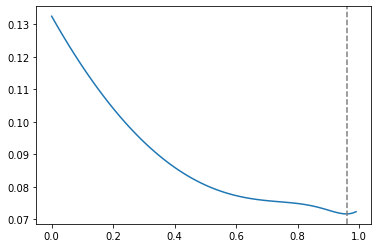

In [18]:
rs = np.arange(0, 1, 0.01)
models = [glsar("Y ~ X", df, rho=r).iterative_fit(maxiter=1) for r in rs]
sse = [m.ssr for m in models]
print((np.argmin(sse), rs[np.argmin(sse)], sse[np.argmin(sse)]))

plt.plot(rs, sse)
plt.axvline(x=rs[np.argmin(sse)], color='grey', linestyle='dashed')
plt.show()

In [19]:
ar1 = glsar("Y ~ X", df, rho=rs[np.argmin(sse)]).iterative_fit(maxiter=1)
display(anova_lm(ar1))
ar1.summary()

,df,sum_sq,mean_sq,F,PR(>F)
X,1.0,110.256878,110.256878,26152.311307,1.541843e-28
Residual,17.0,0.071671,0.004216,NaN,NaN


C:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.970
Model:                          GLSAR   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     550.3
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           2.18e-14
Time:                        17:30:31   Log-Likelihood:                 26.051
No. Observations:                  19   AIC:                            -48.10
Df Residuals:                      17   BIC:                            -46.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7793      1.449      1.228      0.236      -1.279       4.837
X              0.1605      0.007     23.458      0.000       0.146       0.175
==============================================================================
Omnibus:                        0.135   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.935   Jarque-Bera (JB):                0.061
Skew:                           0.076   Prob(JB):                        0.970
Kurtosis:                       2.769   Cond. No.                         825.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 12.6 (p 497)

First Differences and Regression Results with First Differences Procedure -- Blaisdell Company Example

> Since the autocorrelation parameter $\rho$ is frequently large and SSE as a function of $\rho$ often is quite flat for large values of $\rho$ up to $1.0$, as in the Blaisdell Company example, some economists and statisticians have suggested use of $\rho=1.0$ in the transformation model (12.17). 

With $\rho=1$, model (12.17) simplifies greatly to (12.29)

$Y^{'}_t = \beta^{'}_t X^{'}_t + u_t$

With the transformed variables defined accordingly. To transform back to (12.1) according to 

$b_0 = \bar{Y} - b^{'}_t \bar{X}$

$b_1 = b^{'}_1$

##### Note

Unlike previous tests, using the GLSAR function does not produce equialent results, for whatever reason. Therefore, since first differencing is so easy in Pandas, it is natural to just fit a normal OLS regression model. 

In [20]:
pd.DataFrame({
    "(1) Y": df.Y,
    "(2) X": df.X,
    "(3) Y'": df.Y.diff(),
    "(4) X'": df.X.diff()
})

,(1) Y,(2) X,(3) Y',(4) X'
0,20.96,127.3,NaN,NaN
1,21.40,130.0,0.44,2.7
2,21.96,132.7,0.56,2.7
3,21.52,129.4,-0.44,-3.3
4,22.39,135.0,0.87,5.6
5,22.76,137.1,0.37,2.1
6,23.48,141.2,0.72,4.1
7,23.66,142.8,0.18,1.6
8,24.10,145.5,0.44,2.7
9,24.01,145.3,-0.09,-0.2


In [21]:
model = ols("Y ~ 0 + X", pd.DataFrame({"Y": df.Y.diff(), "X": df.X.diff()})).fit()
display(anova_lm(model))
model.summary()

,df,sum_sq,mean_sq,F,PR(>F)
X,1.0,5.263726,5.263726,1093.143324,1.435445e-17
Residual,18.0,0.086674,0.004815,NaN,NaN


C:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              1093.
Date:                Tue, 01 Jun 2021   Prob (F-statistic):                    1.44e-17
Time:                        17:30:35   Log-Likelihood:                          24.246
No. Observations:                  19   AIC:                                     -46.49
Df Residuals:                      18   BIC:                                     -45.55
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.1685      0.005     33.063      0.000       0.158       0.179
==============================================================================
Omnibus:                        0.373   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.830   Jarque-Bera (JB):                0.515
Skew:                           0.197   Prob(JB):                        0.773
Kurtosis:                       2.296   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 12.7 (p 498)

Major Regression Results for Three Transformation Procedures -- Blaisdell Company Example

##### Note

I refit all the models accordingly, using the standard OLS with the simple tricks to shift difference the data sets appropriately. In the case of Cochrane-Orcutt, this needs iteration to get convergence. If you do `maxiter=1` you get results matching the text. However, you can see by iterating to a better answer, you get larger, more accurate, standard error estimates, along with slightly lower MSE. 

Important to realize, using `glsar` with `maxiter=1` for Hildreth-Lu $\rho$ we used produces the same results, appropriately. However, if you let this one iterate to convergence, you get the same results as Cochrane-Orcutt. The difference in the *procedure* is that you find the $\rho$ through a grid search that minimizes $SSE$, without iteration. Once found, you just fit the appropriate transformation model (12.16). With Cochrane-Orcutt, the initial $\rho$ doesn't matter as it will converge to an optimal rho value.

My hope here is to show that implementing any of these is not particularly difficult, and we don't just have to take first-differencing as the default option. If anything, try `glsar` and identify its optimal $\rho$ (0.8369, btw). Do a grid search to see if $SSE$ is minimized around $\rho=1$. If they all agree in large $\rho$, then it's fine to just go with the easier approach of first differences. If there is deviation from that, it's worth exploring!

I leave it as an exercise to find an easy way to recover the original untransformed models, especially with all the class API that statsmodels provides (use the design matrix?) ...

In [22]:
r = [0.63, 0.96, 1, None]
co = glsar("Y ~ X", df, rho=r[0]).iterative_fit(maxiter=100)
hl = ols("Y ~ X", pd.DataFrame({"Y": df.Y - r[1]*df.Y.shift(), "X": df.X - r[1]*df.X.shift()})).fit()
fd = ols("Y ~ 0 + X", pd.DataFrame({"Y": df.Y.diff(), "X": df.X.diff()})).fit()
ol = ols("Y ~ X", df).fit()

pd.DataFrame({
    "b1": [co.params[1], hl.params[1], fd.params[0], ol.params[1]],
    "s{b1}": [co.bse[1], hl.bse[1], fd.bse[0], ol.bse[1]],
    "r": r,
    "MSE": [co.mse_resid, hl.mse_resid, fd.mse_resid, ol.mse_resid]
}, index = ["Cochrane-Orcutt", "Hildreth-Lu", "First Differences", "OLS"])

,b1,s{b1},r,MSE
Cochrane-Orcutt,0.168282,0.004997,0.63,0.004373
Hildreth-Lu,0.160454,0.006840,0.96,0.004216
First Differences,0.168488,0.005096,1.00,0.004815
OLS,0.176283,0.001445,NaN,0.007406


Would be nice to see how the model translates into a visual fit and comparison of the differently fitted models, along with a comparison of the residuals visually.

# 12.5 Forecasting with Autocorrelated Error Terms (p 499)

### Examples (p 499-500)

This will be TBD as for now this is all just doing math in python. Read the book if you really want the details!